In [1]:
# Necessary imports for this walkthrough
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import keras

In [2]:
# Used as the baseline callback for the training session
# A bit buggy due to the way that accuracy is measured
class TerminateOnBaseline(keras.callbacks.Callback):
    """Callback that terminates training when either acc or val_acc reaches a specified baseline"""
    def __init__(self, monitor, baseline):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = baseline

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get(self.monitor)
        if acc is not None:
            if acc >= self.baseline:
                print('Epoch {}: Reached baseline with value {}, terminating training on next iteration'.format(epoch+1, logs[self.monitor]))
                self.model.stop_training = True

# Plots a 2D decision boundary given the input training data
def plotDecisionBoundary(predFx, XTrain, YTrain, relDistVal = 1, stepSize = 0.025):
    x_min, x_max = XTrain[:, 0].min() - relDistVal, XTrain[:, 0].max() + relDistVal
    y_min, y_max = XTrain[:, 1].min() - relDistVal, XTrain[:, 1].max() + relDistVal
    xx, yy = np.meshgrid(np.arange(x_min, x_max, stepSize),
                         np.arange(y_min, y_max, stepSize))


    # Plot decision boundary
    fig, ax = plt.subplots()
    Z = predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu)
    ax.scatter(XTrain[:, 0], XTrain[:, 1], c=YTrain, cmap=plt.cm.RdBu)
    ax.axis('off')
    ax.set_title("Decision Boundary for XOR Problem")

# Tiny TensorFlow Tutorial
Most of this information can be found on the Face Recognition tutorial which you can find [here](https://sites.google.com/view/ece-196/face-recognition/intro-to-keras). It will not be necessary to read this guide for this particular section, but it will become largely useful for the CNN portion of this class.

## Functional Paradigm
Currently, the most convenient way to implement TensorFlow models is to use the eager execution environment. While there are some benefits to executing static graphs for a self-contained model, eager execution allows stop-point execution of TF code. This generally means that lines that correspond to specific operations do indeed get executed in a predictable way. In our case, we simply use the eager environment because there's no downside. Furthermore, since Keras has become a first-class citizen in TensorFlow, we will also be using it to simplify the creation of models that use basic layers.

However, before we get into the design of models using these predefined layers, we should establish how exactly programming using TensorFlow works. To summarize the page above, the typical paradigm for creating networks using TensorFlow is the functional paradigm. The reason it is known as the functional paradigm is due to the way that the data flow is determined by the use of layer functors (see the Python introduction in the FR guide). Each operation can be summarized as a layer instantiation followed by a layer execution in the following manner:

```python
output = LayerType(initPosArgs*, initKWArgs**)(input)
```

In the above example, the initArgs represents the possible positional and keword arguments that can be passed in order to initialize the LayerType layer. Finally, the input to the layer is passed into the layer immediately following the intialization of the layer through a function call. This will be the way most functions function when using the Keras interface of TensorFlow, and the TF environment has made this type of operation very consistent for even activation layers. At this point, I strongly suggest looking at the above introduction page in order to familiarize yourself with the functions that will be used in this session. Note that the only layer that will be used for this particular notebook is the Dense layer, which functions as a fully connected layer.

## Relevant Layers
Please take a look at [this](https://sites.google.com/view/ece-196/face-recognition/intro-to-keras#h.p_sV-YQ6VxoL_r) subsection of the Keras tutorial in order to see what layers will be relevant for this assignment. The only other layer which is not covered in the linked guide is the input layer, which will be covered in the example below. For now, it's more important to understand the connections between the layer implementation and the conceptual idea of the layer than to memorize the entire API.

# Solving the XOR Problem 
## Introduction
Before starting, recall the typical formulation for a single layer neural network as seen below, where $X$ is our input feature array, $\phi$ is the activation function, and $W$ defines the set of weights used in the network:
![Neural Model](./images/singlelayer.png)


$$ Y = \phi\left(WX+b\right) $$

These "layers" of neurons form the building blocks of basic feed-forward neural networks. Thus, an implementation for a three layer neural network would look as follows (where $P$ is simply whatever set of preprocessed features we have):
![Neural Model 3](./images/threelayer.png)


$$\begin{align*}
X &\leftarrow P \\
A_1 &= \phi_1\left(W_1X+b_1\right) \\
A_2 &= \phi_2\left(W_2A_1+b_2\right) \\
Y &= \phi_3\left(W_3A_2+b_3)\right)
\end{align*}$$

Since we are solving a classification problem, we decide to let the final activation function be a sigmoid (more formally, $\phi_3(x)=\frac{1}{1+e^{-x}}$). The inner layers we let be a simple ReLu activation ($\phi_1(x)=\phi_2(x)=\max\left(0,x\right)$). Since a sigmoid can be treated as the probability of an input pertaining to some class, $P(Y=1|X=x)$, this should suffice for the network. If you originally thought of using a multi-class output instead (and thus used a softmax on two outputs neurons instead), notice that by the definition of the softmax function, both of these will simply be complements and thus contain redundant information about the class the sample corresponds to. That being said, the training process would function very similarly due to this observation.

## Problem Specification
The XOR is a classification problem that can be represented with the following visual:
![Problem](./images/xorProb.png)

In other words, we have a set of four points as the possible inputs and wish to train a network in order to be able to identify the class that each of these points corresponds to correctly and deterministically (that is, we don't want the answer to change if we query the network about the same point!). As shown in the lecture slides, there is no linear hyperplane that can be used as the decision boundary for this particular classification problem. Naturally, then, one might consider using a neural network due to its abilities to incorporate non-linearity into its decision boundary...

In [3]:
# Prepares NP arrays for the input data
inDataset = np.array([[1, 0], [0, 1], [0, 0], [1, 1]])
labels = np.array([1, 1, 0, 0]).astype(dtype=np.int)

# Size of the inputs/labels
print(inDataset.shape)
print(labels.shape)

(4, 2)
(4,)


## Model Implementation
With the math laid out above, we can now start implementing a concrete network. Since Keras has since become the dominant way of implementing models using pre-defined layers, we will be using the simpler Keras interface in conjunction with the normal TensorFlow session for the rest of this notebook. So, given the algorithmic view of the three-layer network above, we fill in the blanks and decide upon the following set of properties for use in the network:

  1. Placeholder [Input: $2$] (Reason: $x\in\mathcal{R}^2$)
  2. Fully Connected Layer [Output: $8$, Activation: ReLu]
  3. Fully Connected Layer [Output: $8$, Activation: ReLu]
  4. Output $\rightarrow$ Fully Connected Layer [Output: $2$, Activation: Softmax] (Reason: $y_i=P(Y=i|X=x),i\in\{0,1\}$)
  
In other words, this network will be trained in order to take in some two-dimensional input and output a set of normalized probabilities that correspond to the chances of the output pertaining to some class given the input. The following covers the model generation using Keras layers...

In [4]:
# Implements the network using TensorFlow.Keras
def MLPNetwork():
    # input layer (note that batches are already taken care of for you)
    x = keras.Input(shape=(2,))
    
    # subsequent dense layers
    a1 = keras.layers.Dense(8, activation='relu')(x)
    a2 = keras.layers.Dense(8, activation='relu')(a1)
    
    # classification dense layer
    logits = keras.layers.Dense(1, activation='sigmoid')(a2)
    
    # Creates the model given the above structure
    model = keras.Model(inputs=x, outputs=logits)
    return model

MLPmod = MLPNetwork()
MLPmod.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


## Model Training
With the model declared and the proper summary output, we can now use our input data and labels to train the network.

Generally, with Tensorflow, optimization follows a series of steps as follows:

1. Declare your model [Finished]
2. Declare the optimizer
3. Declare the loss function
4. Compile the model using the above (or manage the gradient tapes manually)
5. Fit the compiled model on the input training data

Given our simple problem, there is no reason to choose any particular optimizer. To make things simpler, we choose the vanilla SGD optimizer as it requires the least fussing around. The loss function is clearly going to be the categorial cross-entropy loss as our problem is a multi-class classification problem. Finally, since we do not have any business dealing with the gradients manually, we can use the compile function to deal with the gradient application on its own.

In [5]:
# Sets up the optimizer for use
opt = keras.optimizers.SGD(learning_rate=0.5)

# Trains the network using the given input data and labels
MLPmod.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# The callback forces the network to train until it reaches 100% accuracy
hist = MLPmod.fit(inDataset, labels, epochs=100, callbacks=[TerminateOnBaseline(monitor="accuracy", baseline=1.0),])

Train on 4 samples
Epoch 1/100
4/4 [==============================] - 0s 110ms/sample - loss: 0.7181 - accuracy: 0.5000
Epoch 2/100
4/4 [==============================] - 0s 748us/sample - loss: 0.6995 - accuracy: 0.2500
Epoch 3/100
4/4 [==============================] - 0s 998us/sample - loss: 0.6904 - accuracy: 0.5000
Epoch 4/100
4/4 [==============================] - 0s 997us/sample - loss: 0.6825 - accuracy: 0.5000
Epoch 5/100
4/4 [==============================] - 0s 997us/sample - loss: 0.6792 - accuracy: 0.5000
Epoch 6/100
4/4 [==============================] - 0s 997us/sample - loss: 0.6748 - accuracy: 0.7500
Epoch 7/100
4/4 [==============================] - 0s 997us/sample - loss: 0.6693 - accuracy: 0.7500
Epoch 8/100
4/4 [==============================] - 0s 748us/sample - loss: 0.6653 - accuracy: 0.7500
Epoch 9/100
4/4 [==============================] - 0s 997us/sample - loss: 0.6629 - accuracy: 0.7500
Epoch 10/100
4/4 [==============================] - 0s 997us/sample - lo

## Results & Analysis
As seen above, despite the seemingly large learning rate, the network was able to succesfully train itself to a 100% accuracy. Notice, however, that the loss is still non-zero. This makes sense since the surface that we are training the network on (probabilities), has a large range of values, and all that is necessary in order to ensure the proper answer is that $P(Y=i_{\text{true}}|X=x)\ge0.5$ for the true class of sample $x$, $i_{\text{true}}$. Further training can possible lead to a smaller loss value, but further training may also lead to the possibility of overfitting the training dataset.

With this in mind, we would like to see the decision boundary out of interest. Even though our network has succesfully trained on the training set, looking at the decision boundary will tell us about the amount of effort that the network put into learning this function mapping and whether or not it makes sense for the decision boundary to look as such...

__NOTE:__ The network above may sometimes give an accuracy of 1.0 but still be incorrect once plotted by the decision boundary function. Since the accuracy function rounds logits values, it's possible for the network to confuse a value close to $0.5$ as potentially coming from either class and thus contributing the the overall accuracy despite being incorrect. If this happens, just rerun the notebook so it learns a new function or run the box above one more time.

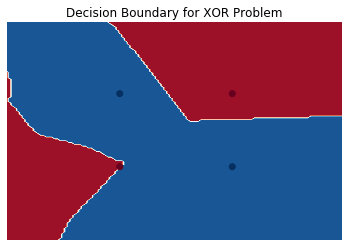

In [6]:
# Designate a prediction lambda to form our predictions from an input
predict = lambda x_test:np.round(MLPmod.predict(x_test))

# Now plot this decision boundary across some uniform set of X and Y coordinates to visualize the decision boundary    
plotDecisionBoundary(predict, inDataset, labels)

### Analysis
One of the most important questions to ask after training a network is the following: Does the output make any sense? If you run the above code many times, you will see that many different types of decision boundaries are generated for this problem. More likely than not, all of these boundaries will have been able to solve the XOR problem. So, yes, the output makes sense in the context of the XOR problem.

The real problem with answering this question comes with generalization, however. The XOR problem has properly generalized to the input domain space (specifically the four points defining the XOR problem), but, say that instead of being limited to this space, we have a continuum of points on the line created by the two red dots. That is, there are infinitely many points corresponding to the blue and red classes. It should be clear that if the true form of one class was a line on the 2D plane, then the neural network can possible fail to generalize properly, despite the points given being a proper representation of that problem as well. An example of this failure can be seen in the decision boundary below:
![Possible Result](toothpick.png)

Make sure to keep this in mind. Your network results are heavily dependent on the way that the input dataset is set up. If you give a dataset that is not well representative of your input space (in the XOR case, we actually used ALL possible points of the input domain!), then you will likely produce garbage results that form either due to an overfitting of points or a fitting of an incorrect data distribution.